<a href="https://www.kaggle.com/code/burcakaydn/multi-class-classification?scriptVersionId=174185445" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

2024-04-26 18:02:44.744175: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 18:02:44.744324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 18:02:44.909010: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df_train = '/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv'
df_validation = '/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv'

In [3]:
with open(df_train) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

In [4]:
def parse_data_from_input(filename):
  """
  Parses the images and labels from a CSV file

  Args:
    filename (string): path to the CSV file

  Returns:
    images, labels: tuple of numpy arrays containing the images and labels
  """
  with open(filename) as file:

    # Use csv.reader, passing in the appropriate delimiter
    # Remember that csv.reader can be iterated and returns one line in each iteration
    csv_reader = csv.reader(file, delimiter=',')


    # Skip the header
    next(csv_reader)

    # Initialize lists to store labels and images
    labels_list = []
    images_list = []

    # Process each row in the CSV file
    for row in csv_reader:
        # The first item is the label
        labels_list.append(int(row[0]))
        # The remaining items are the pixel values, reshaped from 784 to 28x28
        image = np.array(row[1:], dtype=np.float64).reshape(28, 28)
        images_list.append(image)

    # Convert lists to numpy arrays with type float64
    labels = np.array(labels_list, dtype=np.float64)
    images = np.array(images_list, dtype=np.float64)


    return images, labels

In [5]:
training_images, training_labels = parse_data_from_input(df_train)
validation_images, validation_labels = parse_data_from_input(df_validation)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


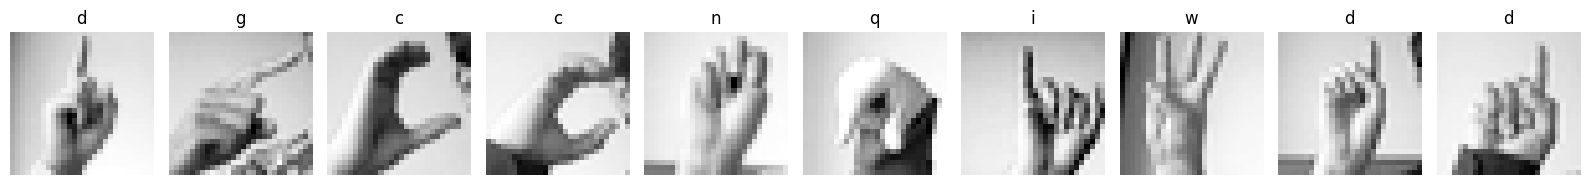

In [6]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

In [7]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  """
  Creates the training and validation data generators

  Args:
    training_images (array): parsed images from the train CSV file
    training_labels (array): parsed labels from the train CSV file
    validation_images (array): parsed images from the test CSV file
    validation_labels (array): parsed labels from the test CSV file

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """

  # In this section you will have to add another dimension to the data
  # So, for example, if your array is (10000, 28, 28)
  # You will need to make it (10000, 28, 28, 1)
  # Hint: np.expand_dims
  training_images = np.expand_dims(training_images, axis=3)
  validation_images = np.expand_dims(validation_images, axis=3)
  # Instantiate the ImageDataGenerator class
  # Don't forget to normalize pixel values
  # and set arguments to augment the images (if desired)
  train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )


  # Pass in the appropriate arguments to the flow method
  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32)

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator(
      rescale=1./255
      )

  # Pass in the appropriate arguments to the flow method
  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32)

  return train_generator, validation_generator

In [8]:
# Test your generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_model():

  # Define the model
  # Use no more than 2 Conv2D and 2 MaxPooling2D
  model = Sequential([
          # Convolutional layer 1
          Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
          MaxPooling2D(2, 2),

          # Convolutional layer 2
          Conv2D(64, (3,3), activation='relu'),
          MaxPooling2D(2,2),

          # Flattening the output of the convolutional layers to feed into the dense layer
          Flatten(),

          # Dense layer for classification
          Dense(128, activation='relu'),

          # Output layer with 25 units for 25 classes (A-Y) and softmax activation
          Dense(25, activation='softmax')
      ])


  model.compile(optimizer = 'adam',
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


  return model

In [10]:
model = create_model()

# Train your model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 33s 36ms/step - accuracy: 0.1029 - loss: 3.0060 - val_accuracy: 0.3279 - val_loss: 1.8902
Epoch 2/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.3309 - loss: 2.1152 - val_accuracy: 0.6089 - val_loss: 1.1965
Epoch 3/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 0.4463 - loss: 1.7250 - val_accuracy: 0.6015 - val_loss: 1.1798
Epoch 4/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.5262 - loss: 1.4582 - val_accuracy: 0.6757 - val_loss: 0.9808
Epoch 5/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.5714 - loss: 1.3135 - val_accuracy: 0.7352 - val_loss: 0.7618
Epoch 6/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - accuracy: 0.6148 - loss: 1.1781 - val_accuracy: 0.7408 - val_loss: 0.7593
Epoch 7/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 0.6398 - loss: 1.1096 - val_accuracy: 0.7518 - val_loss: 0.6998
Epoch 8/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.6662 - loss: 1.0142 - val_accurac

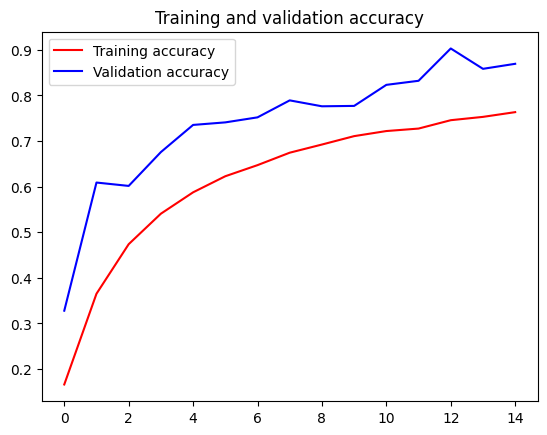

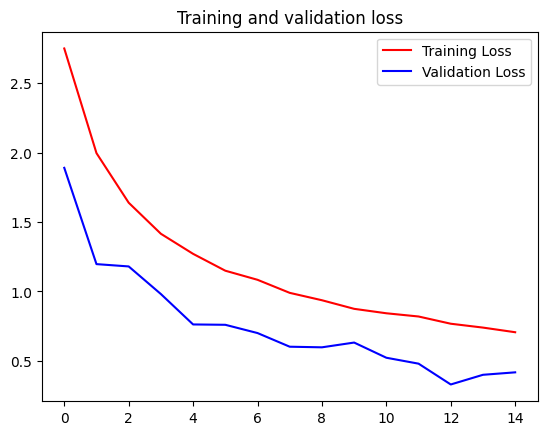

In [11]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()